# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
#n_records = None
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = 0
for _, person in data.iterrows():
    if person['income'] == '>50K':
        n_greater_50k += 1
    else:         
        pass

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = 0
for _, person in data.iterrows():
    if person['income'] == '<=50K':
        n_at_most_50k += 1
    else:         
        pass

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)/(n_greater_50k+n_at_most_50k))*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

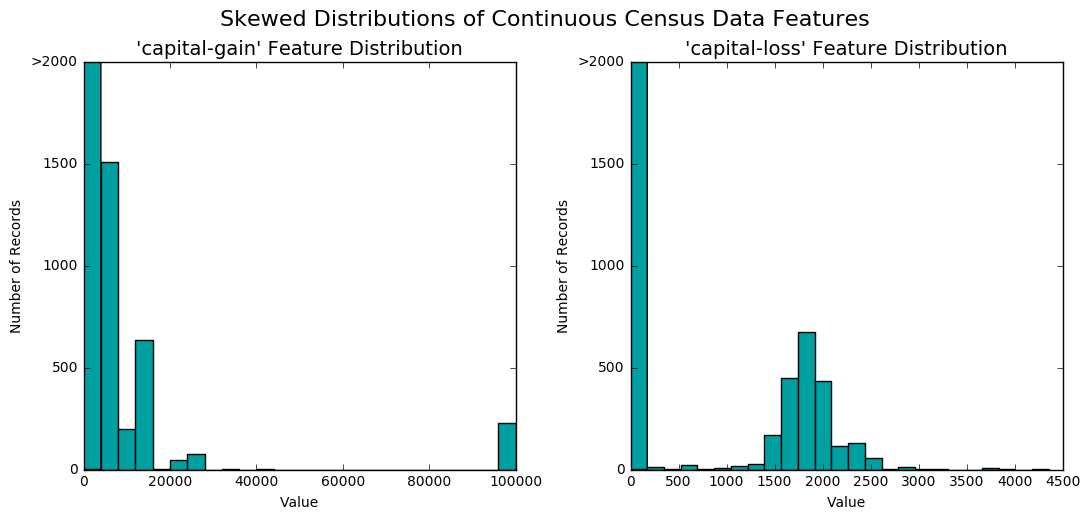

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

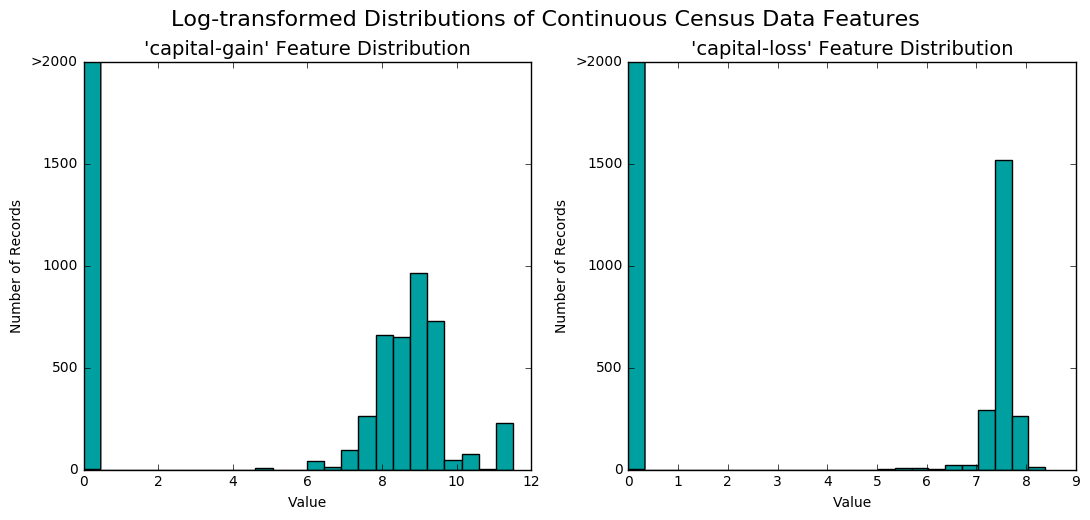

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
#income_full = pd.get_dummies(income_raw)
#income = income_full['>50K']
#income_full = pd.get_dummies(income_raw)['>50K']
income = pd.get_dummies(income_raw)['>50K']

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
#print list(income.columns)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [9]:
# TODO: Calculate accuracy
#accuracy = None
#greater_percent = (float(n_greater_50k)/(n_greater_50k+n_at_most_50k))*100

accuracy = float(greater_percent)/100

# TODO: Calculate F-score using the formula above for beta = 0.5
#fscore = None

#recall = (float(n_at_most_50k)/(n_greater_50k+n_at_most_50k))
recall = float(n_greater_50k)/(n_greater_50k+0)
beta = float(0.5)
fscore = (1+beta*beta)*accuracy*recall/((beta*beta)*accuracy+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)
print recall
print accuracy
print beta
print fscore

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
1.0
0.247843969749
0.5
0.291729135432


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: *Decision Trees, Support Vector Machines, Gaussian Naive Bayes

Decision Trees
- real world application: Molecular biology - decision trees are used for analyzing amino acid sequences in projects such as Human Genome Project or GenBank. References:
    1. STEVEN SALZBERG. Locating protein coding regions in human DNA using a decision tree algorithm. Journal of Computational Biology, 1995
    2. S. SHIMOZONO, A. SHINOHARA, T. SHINOHARA, S. MIYANO, S. KUHARA, AND S. ARIKAWA. Knowledge acquisition from amino acid sequences by machine learning system BONSAI. Transactions of the Information Processing Society of Japan, 35(10):2009--2018, October 1994.
- strengths: decision trees can be relatively easy to interpret and can be thought of as a "white box" solution, fast training and testing, robust to noise and missing values
- weakness: if many levels of trees exist then complexity of interpretation also rises, possibility of duplication within the trees
- why candidate? Decision Trees are one of the most known classificaiton methods and it suits the problem as hand as given the dataset it looks that features allow to implement DT algorithm, there should be enough of data, it should be possible to generalize and not to overfit, algorithm is fast in training and testing. 

Support Vector Machines
- real world application: Facial expression classification using statistical models of shape and SVM's. References:
    1. J. Ghent and J. McDonald, "Facial Expression Classification using a One-Against-All Support Vector Machine", proceedings of the Irish Machine Vision and Image Processing Conference, Aug 2005.
    2. J. Ghent and J. McDonald, "Holistic Facial Expression Classification", SPIE Opto-Ireland, pp 5823-18, April 2005. 
- strengths: SVM is able to model complex and nonlinear relationships and thanks to maximizing margins is robust to noise
- weakness: it is needed to select a good kernel function, difficulty of interpretation of model parameters, it can happen that ther eare some numerical stability problems, the algorithm can require significant memory and processing power
- why candidate? SVM is one of the widely used methods for classification problems. Judging from the number of features and their possible values it seems that the problem might be also quite complex with which it might be good to use an algorithm that can handle complexity very well and SVM seems like a good choice.

Gaussian Naive Bayes
- real world application: Gaussian Naive Bayes is used in the field of medical diagnosis for determining which diseases or conditions can be explained based on symptoms and signs. Reference:
    1. Rish, Irina (2001). An empirical study of the naive Bayes classifier (PDF). IJCAI Workshop on Empirical Methods in AI.
- strengths: Gaussian NB is relatively easy and fast to implement, it doesn’t require too much memory and as such can be used for online learning, it is also rasy to understand and it takes into account prior knowledge
- weakness: Gaussian Naive Bayes fails to estimate rare occurences, it suffers from irrelevant features and has a strong and unrealistic feature independence assumptions
- why candidate? Gaussian Naive Bayes is a good candidate as it is a classification method, we can take advantage of previous knowledge and it should be relatively easy to use.*

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    #learner = learner.fit(X_train[:300], y_train[:300])
    end = time() # Get end time

    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    #predictions_train = learner.predict(X_train[:sample_size])
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    #results['acc_train'] = accuracy_score(predictions_train, y_train[:sample_size])
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    #results['f_train'] = fbeta_score(y_train[:sample_size], predictions_train, average='macro', beta=0.5)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average='macro', beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, average='macro', beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', 

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.


C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', 

DecisionTreeClassifier trained on 36177 samples.
SVC trained on 362 samples.


C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


SVC trained on 3618 samples.


C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', 

SVC trained on 36177 samples.
GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.


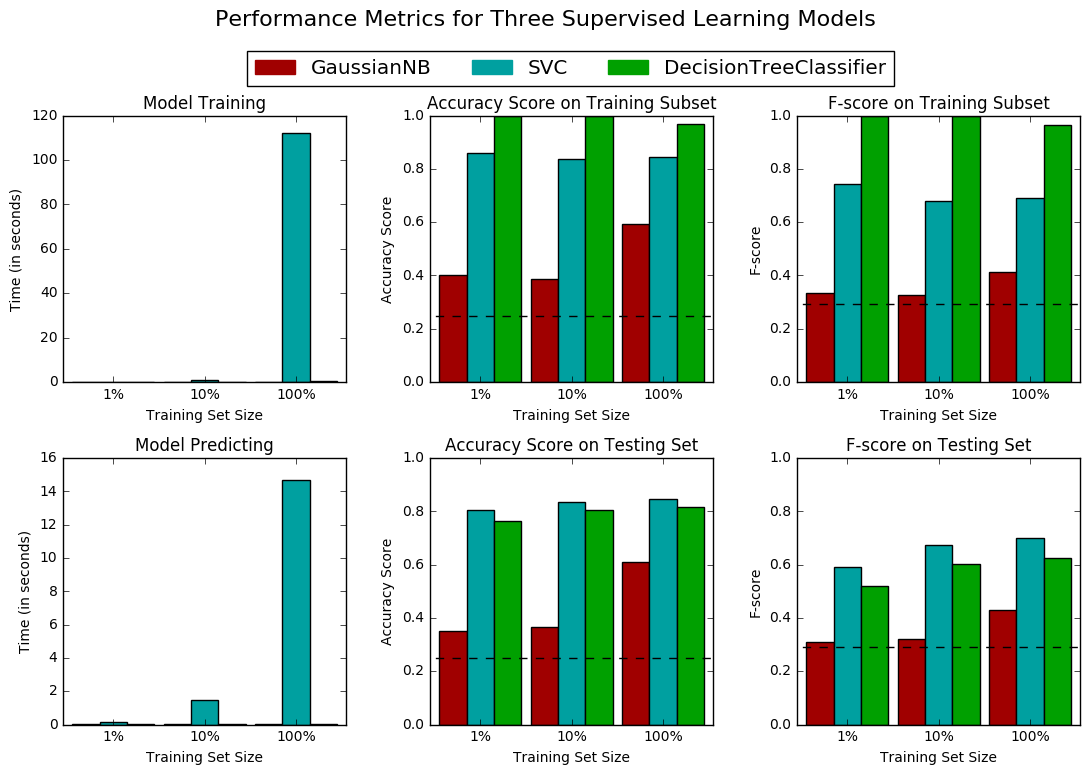

In [13]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=1)
clf_B = SVC(kernel="linear", random_state=1)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
#samples_1 = round(float(len(X_train))*0.01)
#samples_10 = round(float(len(X_train))*0.1)
#samples_100 = float(len(X_train))*1
samples_1 = int(round(len(X_train)*0.01))
samples_10 = int(round(len(X_train)*0.1))
samples_100 = int(len(X_train)*1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: *The choice for the best model for prediction of who makes more than $50,000 depends on what is the most important criterium and metrics for the decision and there are essentially two alternatives:
1. Support Vector Machine is the best model if the most important metrics are accuracy and f-score. SVM shows the best values for both of these metrics but has other drawbacks realted to computational time required for training and prediction (see discussion below for more details). In case of CharityML example it seems that the computational time should not be relevant so then SVM should be the best choice.
2. Decision Trees are the best model if the important metrics include accuracy and f-score but also prediction and training times are of the essence. DTs show good performance in accuracy and f-score with pretty high values with only SVM being slighltly better, howeve SVM computational times for training and prediction are significantly higher than DT. If one was to prioritize the time as well then perhaps the DTs would be the best model to take. Additional argument which could be taken into account is that the DTs seem to be more prone to overfitting when looking at the training set results. Accuracy and f-score values for DTs seem to go to almost 1 for training set and drop for the predicted set.

While Support Vector Machines and Decision Trees show to be both relatively good candidates with some slight differences then the Naive Bayes seems to be not the most appropriate algorithm at all for the task of identifying individuals with an income of more than $50,000 (see detailed discussion on the metrics below).

Metrics discussion:
 - Accuracy score: Decision Trees provide relatively high accuracy measured on the test set of around 0.75, 0,79 and 0,81 for sets of 1%, 10% and 100% of samples from the training set respectively. It is the second best performance after Support Vector Machine which is ahead in terms of accuarcy however it has other drowbacks (described under Model Training & Model Prediction Times). Naive Bayes is well behind the two aforementioned algorithms of Decision Trees and Support Vector Machines and can reach only about 0.6 of accuracy.
 - F-score: Similar behaviour as for accuracy with the only difference in absolute values however the relationship of different models performance in f-score seems to be similar as in accuracy score.
 - Model Training & Model Prediction Times: Decision Trees and Naive Bayes seem to outperform Support Vector Machines in terms of both training and prediction times. We can clearly see the raise in the time needed for both tasks for SVM growing from below 1 second to around 5 to around 120 seconds for training and also below 1 second, around 3 seconds and around 75 seconds for prediction times where for both the sample sizes grow from 1%, 10% to 100% correspondingly for the aforementioned scores. For Decision Trees and Naive Bayes these times are completely insignificant and are not even noticable.*

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: *The final model chosen is Support Vector Machines. SVM in this example is used as a classification algorithm which outputs only two types of labels of income (below & equal and the second one above for values of income above $50,000).

- To predict those labels the algorithm uses already known information from the census where some features are collected and the actual income level about the people. This us used to train the model to divide all the new inserts into it to output one of the two income labels.
- The algorithm classifieds the people according to their income level using a special function which creates a boundary between people based on the input data (age, education level etc.).
- Sometimes the input information in its format of basic features still does not allow to draw clearly a boundary dividing between income classes. In this case the SVM algoriithm can handle it by rearranging or combining already existing features to create a new feature which allows for a clear boundary using a hyperplane. This method is called a kernel trick which uses higher dimensions of features to separate between different income levels of new entries.
- at the end when we input few basic information about a person into the model (age, education etc.) the algorithm will spit out the inome level of below or above 50k$.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [15]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score

# TODO: Initialize the classifier
clf = SVC(kernel="linear")

# TODO: Create the parameters list you wish to tune
parameters = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'degree':[2,3]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)
#scorer = fbeta_score(y_test, predictions_test, average='macro', beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8474
F-score on testing data: 0.6996

Optimized Model
------
Final accuracy score on the testing data: 0.8474
Final F-score on the testing data: 0.6996


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |       0.8474      |      0.8474     |
| F-score        |       0.2917        |       0.6996      |      0.6996     |


**Answer: *Optimized Model Scores are 0.8474 for the accuracy score and 0.6996 for the F-score. Both of these values are relatively good and show an acceptable performance. These results are however exactly the same for optimized and unoptimized models which means that within the grid of parameters of the model there was not better performance of the model. In this case for SVM the grid was relatvely narrow and included different kernel functions as well as different degree of polynomials for a polynomial kernel. These all methods however seem to stay exactly as the initially unoptimized model with a linear kernel. Perhaps by using more parameters and their values in the grid search it would be possible to further improve the accuracy and f scores. It would however require even greated computational costs to optimize the model. Both unoptimized and optimized models greatly outperform the benchmark predictor values estimated using naive predictor with results of 0.2478 and 0.2917 for accuracy score and f-score respectively.*

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer: Based on a common sense and general knowledge without exploration of the dataset I would say that the following five features are of the most importance with the following order (1. Age, 2. Hours per week, 3. Education level, 4. Occupation and 5. Work class). Generally speaking the older someone gets more this person makes, then the quantity of working hours would seem relevant and finally three features tied with education, profession and working class seem to play an important role in my judgement.*

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

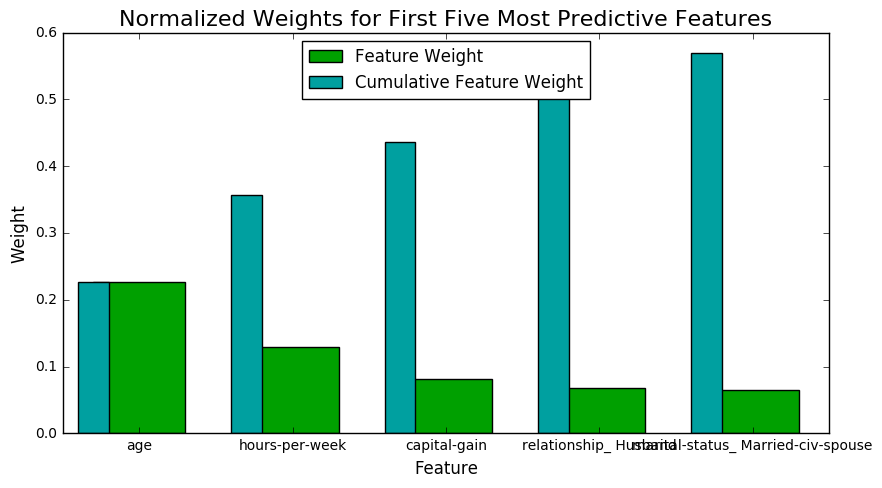

In [17]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# TODO: Train the supervised model on the training set 
clf = ExtraTreesClassifier()
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:*Ranking of importance of features estimated from the function above ranks the five most important features as follows: 1. Age, 2. Hours per week, 3. Capital Gain, 4. Martial status, 5 Relationship. This ranking is the same as I estimated earlier for the first two most important features of Age and Hours per week worked, however features three, four and five differ from my prediction. Feature 3 capital gain captures information which I did not predict in any of my features, the same concerns features 4 and 5 which concern more the private situation of somebody being married or a familyr status. The information carried by those two features does not seem to be captured at all with my choice of features and this is a relevant piece of information for the final income estimation. Moreover the information in the last three features I selected for numbers 3 Education level, 4 Occupation and 5 work class is probably already captured partially by features concerning age and working hours but most likely scenario is that features concerning private family situation is simply more relevant thatn the actual education, occupation or working class as I imagined.*

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8474
F-score on testing data: 0.6996

Final Model trained on reduced data
------
Accuracy on testing data: 0.7966
F-score on testing data: 0.5146


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer: 
Final Model trained on full data (Accuracy on testing data: 0.8474, F-score on testing data: 0.6996)
Final Model trained on reduced data (Accuracy on testing data: 0.7966, F-score on testing data: 0.5146)

As one can see the difference in accuracy between full data model and reduced data model is around 5%. Given much less expensive computation with the reduced data the accuracy is still acceptable and I would consider it if it was important to take the computational cost into account. 

In F-Score the difference between full and reduced data models is significantly higher with around 18%. F-Score can be characterized as a measure of the effectiveness of retrieval with respect to a user who attaches beta  times as much importance to recall as precision. With Beta of 0.5 this difference seems to be significant so for someone considering mostly F-score as a performance metric of the model perhaps the choice of using only reduced data model might not be a good choice.*

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.